# Imports

In [2]:
import os
import glob
import json
import ast
import re

from typing import Dict, List

from src.utils.parsers.cv_parser import fmt_cv_results
from src.utils.visualizers.prediction_figures import PredictionFigures
from src.utils.visualizers.test_figures import TestFigures
from src.utils.visualizers.cv_figures import CVFigures

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, kendalltau
from sklearn.metrics import mean_absolute_error

# Utils

In [3]:
def get_metabolite_info():
    metabolite_data = pd.read_csv('./data/training/metabolites.txt', delimiter='\t')
    raw_metabolites = pd.read_csv('./data/training/metabolites_dataset.data_prep.tsv', delimiter='\t')

    return raw_metabolites.merge(
        metabolite_data, 
        left_on='official_name', right_on='met_name'
    )[['metabolite_id', 'official_name', 'kegg_id', 'pathway', 'method', 'Order']].drop_duplicates().set_index('metabolite_id')

def gather_results(paths: List[str]):
    metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.METABOLITE_CENTRIC_') for path in paths]
    df = pd.concat([
        pd.read_csv(path).assign(metabolite_id=metabolite_name) 
        for path, metabolite_name in zip(paths, metabolites_names)
    ])
    return df

def combine_metabolite_info(df):
    metabolite_info = get_metabolite_info()
    df = df.merge(metabolite_info, left_on='metabolite_id', right_index=True)
    return df

In [4]:
metabolite_info = get_metabolite_info()

# Experiments

## Experiment base (TIER0)

In [5]:
dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0"

test_df_all, test_df_metabolite = None, None
if os.path.exists(f'{dir}/best_model_performance_Strategy.ALL.csv'):
    test_df_all = pd.read_csv(
        f'{dir}/best_model_performance_Strategy.ALL.csv',
        index_col=0
    )
    test_df_all = test_df_all.stack().to_frame().reset_index(1).set_axis(['metabolite_arch', 'r2'], axis=1)
    test_df_all[['metabolite_id', 'architecture']] = test_df_all['metabolite_arch'].str.split("_", expand=True)
    test_df_all = test_df_all.drop('metabolite_arch', axis=1).merge(metabolite_info, left_on='metabolite_id', right_index=True).assign(strategy='all')

if os.path.exists(f'{dir}/best_model_performance_Strategy.METABOLITE_CENTRIC.csv'):
    test_df_metabolite = pd.read_csv(
        f'{dir}/best_model_performance_Strategy.METABOLITE_CENTRIC.csv',
        index_col=0
    )
    test_df_metabolite = test_df_metabolite.stack().to_frame().reset_index(1).set_axis(['metabolite_arch', 'r2'], axis=1)
    test_df_metabolite[['metabolite_id', 'architecture']] = test_df_metabolite['metabolite_arch'].str.split("_", expand=True)
    test_df_metabolite = test_df_metabolite.drop('metabolite_arch', axis=1).merge(metabolite_info, left_on='metabolite_id', right_index=True).assign(strategy='metabolite')

if os.path.exists(f'{dir}/best_model_performance_Strategy.ONE_VS_ALL.csv'):
    test_df_one_vs_all = pd.read_csv(
        f'{dir}/best_model_performance_Strategy.ONE_VS_ALL.csv',
        index_col=0
    )
    test_df_one_vs_all = test_df_one_vs_all.stack().to_frame().reset_index(1).set_axis(['metabolite_arch', 'r2'], axis=1)
    test_df_one_vs_all[['metabolite_id', 'architecture']] = test_df_one_vs_all['metabolite_arch'].str.split("_", expand=True)
    test_df_one_vs_all = test_df_one_vs_all.drop('metabolite_arch', axis=1).merge(metabolite_info, left_on='metabolite_id', right_index=True).assign(strategy='one_vs_all')
    # test_df_metabolite = test_df_metabolite.merge(metabolite_info, left_on='metabolite_id', right_index=True).assign(strategy='metabolite')

test_df = pd.concat([test_df_all, test_df_metabolite, test_df_one_vs_all], axis=0)
test_df = test_df[test_df['architecture'] == 'all']
test_figures = TestFigures(test_df)

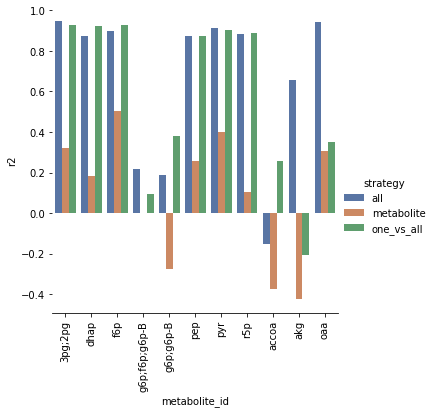

In [6]:
# plt.figure(figsize=(4, 1))
test_figures.r2_per_tier()

### Strategy all

In [10]:
def gather_results_throttle_v2(paths: List[str]):
    throttle_coefficients = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('best_model_performance_Strategy.ALL_throttle').split("__") for path in paths]
    throttle_list = [(throttle, run_id.strip("run")) for throttle, run_id in throttle_coefficients]
    # print(throttle_list)
    df = pd.concat([
        pd.read_csv(path, index_col=0).stack().to_frame().reset_index(1).set_axis(['metabolite_id', 'r2'], axis=1).assign(throttle=throttle).assign(run_id=run_id)
        for path, (throttle, run_id) in zip(paths, throttle_list)
    ])
    return df

In [11]:
dir = "./data/results/experiment_0"
df = pd.read_csv(f'{dir}/Strategy.ALL_all.csv')
df = fmt_cv_results(df)

test_pred_df = pd.read_json(
    f'{dir}/best_model_prediction_performance_Strategy.ALL.json'
)
test_pred_df = test_pred_df.T.reset_index().drop("index", axis=1).set_axis(['y_true', 'y_pred', 'architecture', 'metabolite_id', 'correlation'], axis=1) \
    .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
    .explode(['y_true', 'y_pred'])

# test_throttle_df = gather_results_throttle(glob.glob(dir + "/throttle/best_model*Strategy.ALL*.csv"))
# test_throttle_df = test_throttle_df.sort_values('throttle').merge(metabolite_info, left_on='metabolite_id', right_index=True).reset_index().drop('index', axis=1)

if len(glob.glob(dir + "/throttle/best_model*Strategy.ALL*_run*.csv")) > 0:
    test_throttle_df = gather_results_throttle_v2(glob.glob(dir + "/throttle/best_model*Strategy.ALL*_run*.csv"))
    test_throttle_df = test_throttle_df.sort_values('throttle').merge(metabolite_info, left_on='metabolite_id', right_index=True).reset_index().drop('index', axis=1)
# test_throttle_df.reset_index().drop('index', axis=1)

explanation_df = pd.read_json(f'{dir}/explanations/Strategy.ALL_explanation.json').merge(metabolite_info, left_on='metabolite_id', right_index=True)

#### Model analysis
1. We analyse per model type what their variance is

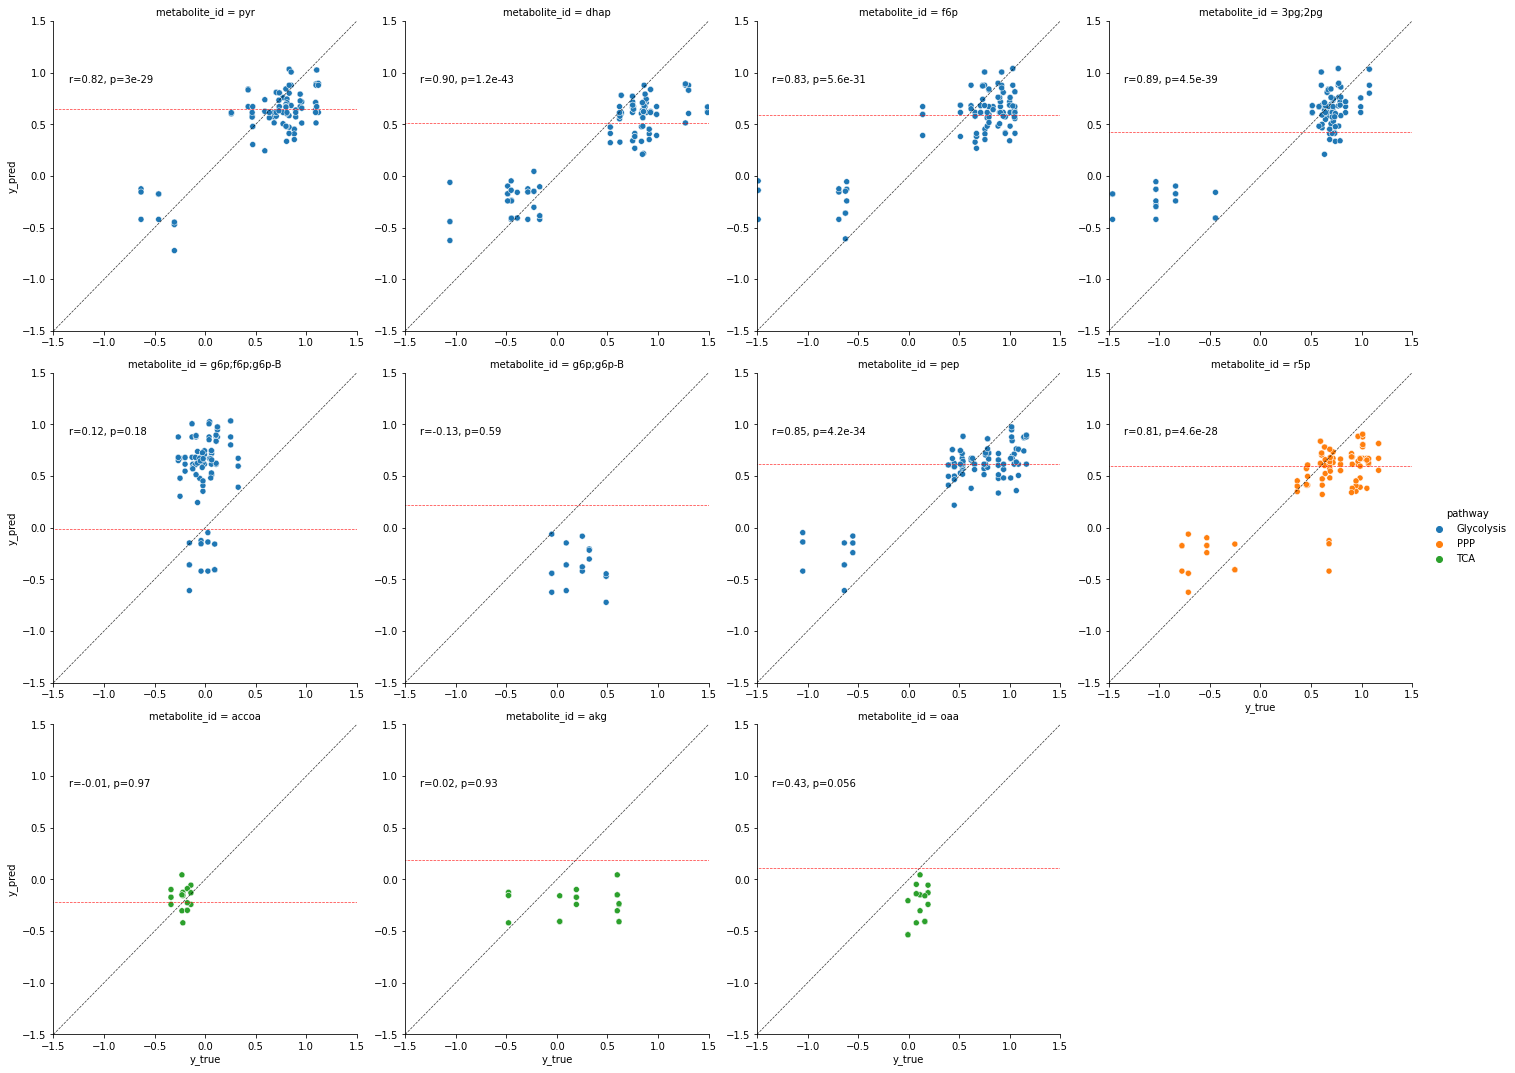

In [12]:
pred_figures = PredictionFigures(test_pred_df)
test_figures = TestFigures(test_df)

pred_figures.prediction_per_metabolite_individual()

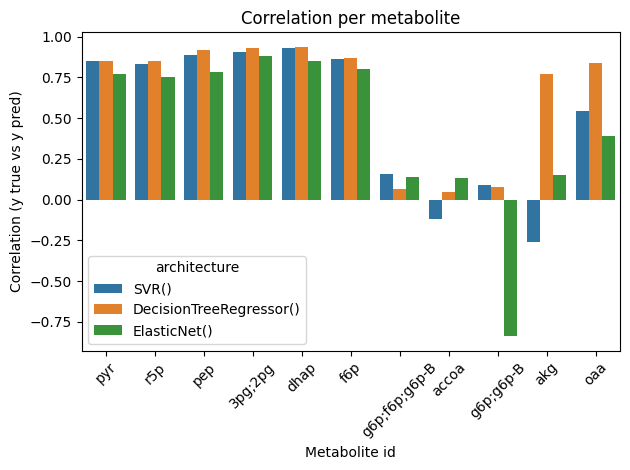

In [14]:
_df = test_pred_df[test_pred_df['architecture'] != 'all']

g = sns.barplot(
    data=_df,
    x='metabolite_id',
    y='correlation',
    hue='architecture'
)
g.axes.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
g.set(xlabel="Metabolite id", ylabel="Correlation (y true vs y pred)", title="Correlation per metabolite")
plt.tight_layout()
plt.savefig('./images/correlation_per_metabolite_model_architectures_specific.svg')

/tmp/ipykernel_433/1029698547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['error'] = mean_absolute_error(_df['y_true'].values.reshape(1, -1), _df['y_pred'].values.reshape(1, -1), multioutput='raw_values')


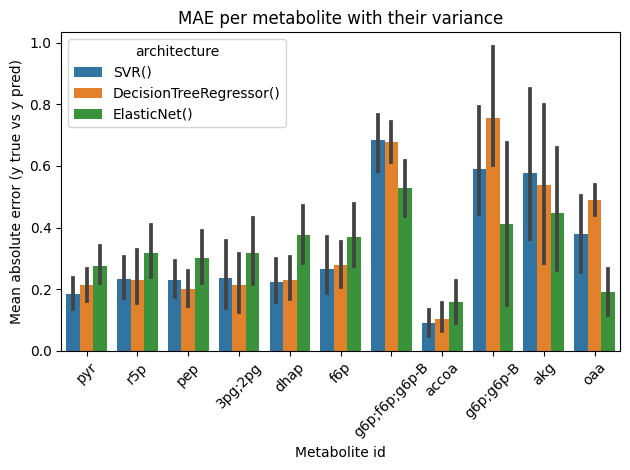

In [23]:
_df = test_pred_df[test_pred_df['architecture'] != 'all']
_df['error'] = mean_absolute_error(_df['y_true'].values.reshape(1, -1), _df['y_pred'].values.reshape(1, -1), multioutput='raw_values')

g = sns.barplot(
    data=_df,
    x='metabolite_id',
    y='error',
    hue='architecture'
)
g.axes.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
g.set(xlabel="Metabolite id", ylabel="Mean absolute error (y true vs y pred)", title="MAE per metabolite with their variance")
plt.tight_layout()
plt.savefig('./images/performance/mae_per_metabolite_model_architectures_specific.svg')
plt.savefig('./images/performance/mae_per_metabolite_model_architectures_specific.png')

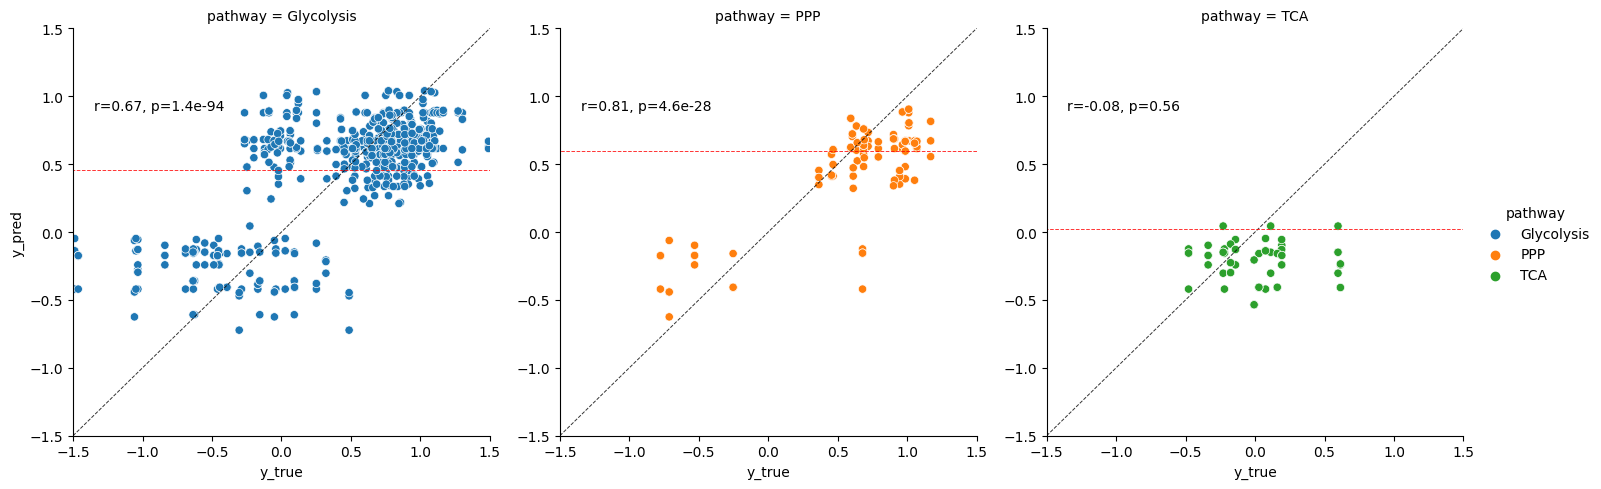

In [22]:
pred_figures.prediction_per_pathway_individual()

plt.savefig('./images/performance/correlation_per_pathway.svg')
plt.savefig('./images/performance/correlation_per_pathway.png')

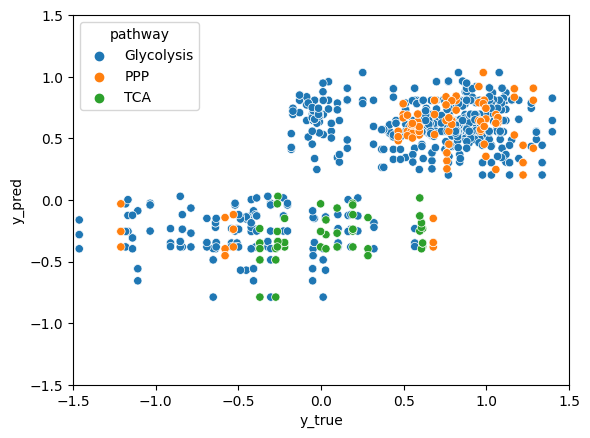

In [41]:
pred_figures.prediction_per_pathway_all()

#### Explanation analysis
1. How many different enzymes are found important per metabolites/pathway
2. Is there a relationship within a metabolite between the different explenations
3. Do we need to account for exp weight

In [16]:
explanation_df

,KO_ORF,metabolite_id,exp_enzymes,exp_weights,y_true,y_pred,official_name,kegg_id,pathway,method,Order
0,YNL020C,pyr,"[YOR280C, YDR378C, YJL171C, YHR146W, YKL060C, ...","[-0.0541763813, 0.034842801900000005, -0.03438...",0.736234,0.805348,Pyruvate,C00022,Glycolysis,TCA,8
1,YIL095W,pyr,"[YCR012W, YOR254C, YBR035C, YJL014W, YPR187W, ...","[0.0277319458, 0.0276160288, -0.0257350159, -0...",0.656326,0.955635,Pyruvate,C00022,Glycolysis,TCA,8
4,YBR274W,pyr,"[YER012W, YML092C, YML028W, YHR042W, YCR012W, ...","[-0.0640487782, -0.032422264900000004, 0.03119...",0.732634,0.435376,Pyruvate,C00022,Glycolysis,TCA,8
15,YAL017W,pyr,"[YPR062W, YAL007C, YLR378C, YGR175C, YHR174W, ...","[-0.051322818400000005, -0.0397319765, 0.02943...",-0.089775,-0.202798,Pyruvate,C00022,Glycolysis,TCA,8
27,YJL057C,pyr,"[YER012W, YPR062W, YGL255W, YML092C, YPL048W, ...","[-0.0626902289, -0.051217732, 0.0484291255, -0...",0.771394,0.424999,Pyruvate,C00022,Glycolysis,TCA,8
...,...,...,...,...,...,...,...,...,...,...,...
93,YBR097W,oaa,"[YGR254W, YDR395W, YIL015W, YDR533C, YHR174W, ...","[0.0344169852, -0.033635680200000004, 0.031344...",-0.206913,0.607377,Oxaloacetate,C00036,TCA,TCA,8
144,YDR122W,oaa,"[YER012W, YGL255W, YPR062W, YJL012C, YDR346C, ...","[-0.061874711400000004, 0.0497573677, -0.04805...",-0.296619,-0.087150,Oxaloacetate,C00036,TCA,TCA,8
182,YHL007C,oaa,"[YJL012C, YHR018C, YLR438W, YIL015W, YLR351C, ...","[0.039423989900000005, -0.0368952958, 0.029511...",-0.403815,-0.369832,Oxaloacetate,C00036,TCA,TCA,8
192,YAR018C,oaa,"[YOR280C, YDR346C, YHR146W, YIL015W, YFL005W, ...","[-0.0557817649, 0.0408632091, -0.0400653576000...",-0.480268,0.283743,Oxaloacetate,C00036,TCA,TCA,8


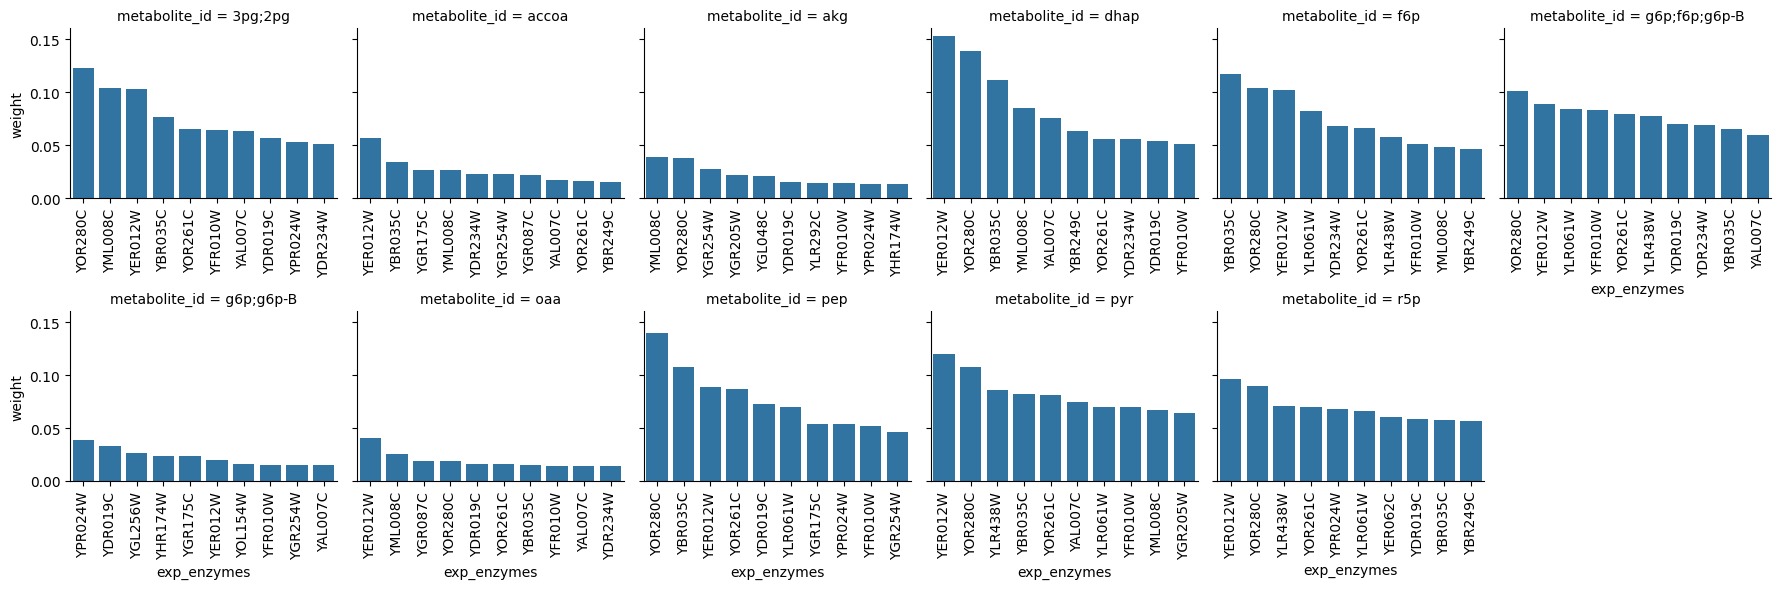

In [9]:
_df = explanation_df.explode(['exp_enzymes', 'exp_weights']).groupby(by=['metabolite_id', 'exp_enzymes'])['exp_weights'].sum().abs() \
    .to_frame('weight').reset_index() \
    .groupby('metabolite_id').apply(lambda x: x.sort_values(by='weight', ascending=False).head(10))

g = sns.FacetGrid(data=_df, col='metabolite_id', col_wrap=6, sharex=False)
g.map_dataframe(sns.barplot, x='exp_enzymes', y='weight')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()

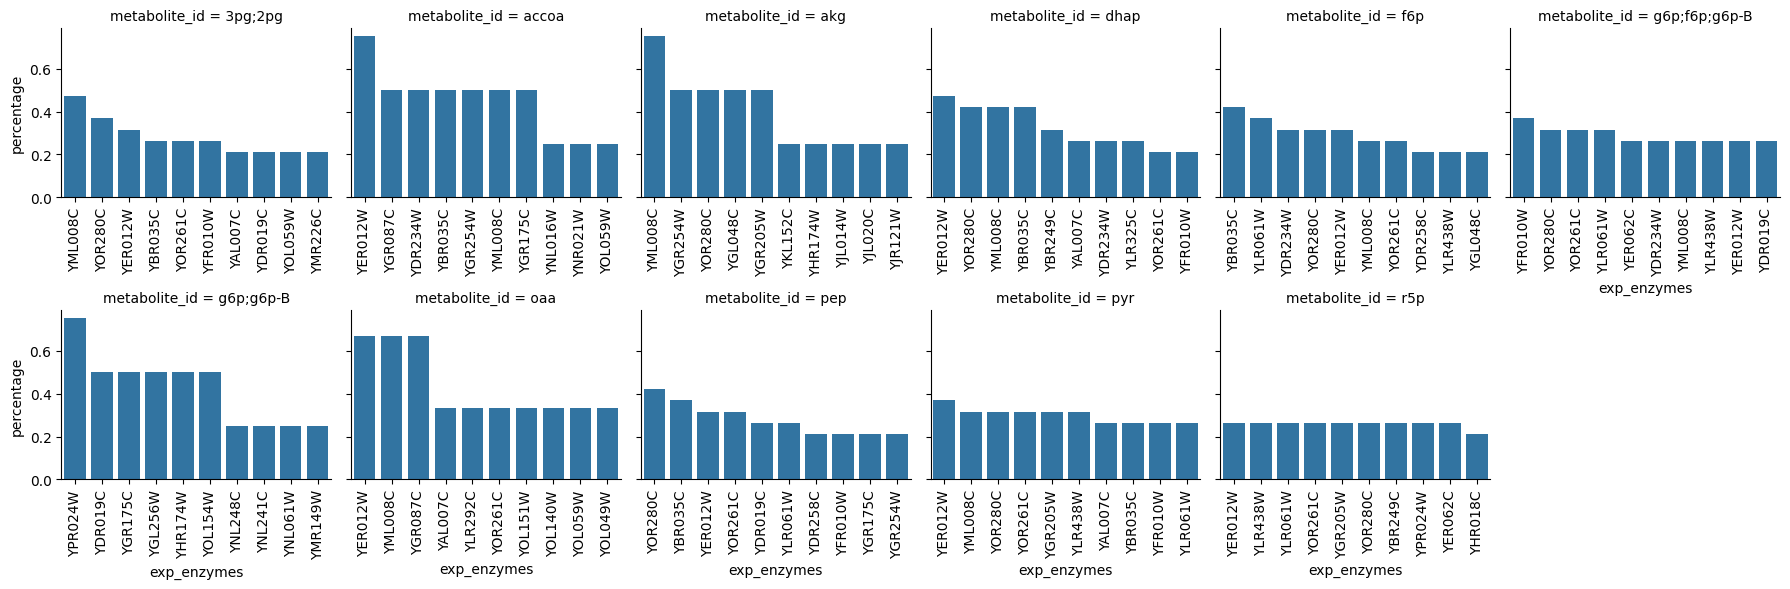

In [33]:
_df = explanation_df.explode(['exp_enzymes', 'exp_weights']) \
    .groupby(['metabolite_id', 'exp_enzymes'])['KO_ORF'].count().to_frame('count').reset_index() \
    .groupby('metabolite_id', as_index=False).apply(lambda x: x.sort_values(by='count', ascending=False).head(10)) \
    
_df = _df.merge(
    right=explanation_df.groupby('metabolite_id').size().to_frame('total'),
    left_on='metabolite_id',
    right_on='metabolite_id'
)
_df['percentage'] = _df['count'] / _df['total']

g = sns.FacetGrid(data=_df, col='metabolite_id', col_wrap=6, sharex=False, sharey=True)
g.map_dataframe(sns.barplot, x='exp_enzymes', y='percentage')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()

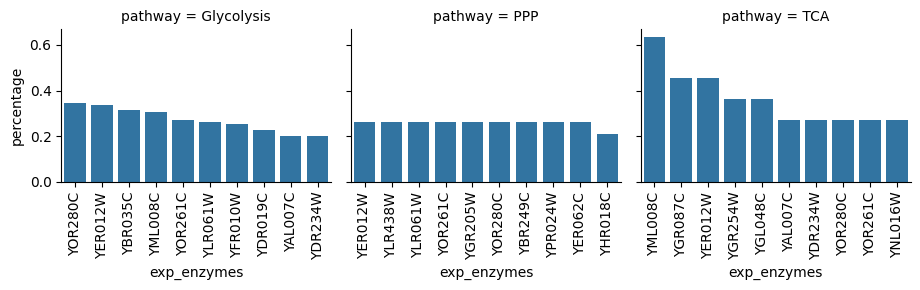

In [37]:
_df = explanation_df.explode(['exp_enzymes', 'exp_weights']) \
    .groupby(['pathway', 'exp_enzymes'])['KO_ORF'].count().to_frame('count').reset_index() \
    .groupby('pathway', as_index=False).apply(lambda x: x.sort_values(by='count', ascending=False).head(10)) \
    
_df = _df.merge(
    right=explanation_df.groupby('pathway').size().to_frame('total'),
    left_on='pathway',
    right_on='pathway'
)
_df['percentage'] = _df['count'] / _df['total']

g = sns.FacetGrid(data=_df, col='pathway', col_wrap=6, sharex=False, sharey=True)
g.map_dataframe(sns.barplot, x='exp_enzymes', y='percentage')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()

In [ ]:
_df = explanation_df.explode(['exp_enzymes', 'exp_weights']) 

g = sns.FacetGrid(data=_df, col='metabolite_id', col_wrap=6, sharex=False)
g.map_dataframe(sns.boxplot, x='exp_enzymes', y='exp_weights')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()

<AxesSubplot:xlabel='y_true', ylabel='y_pred'>

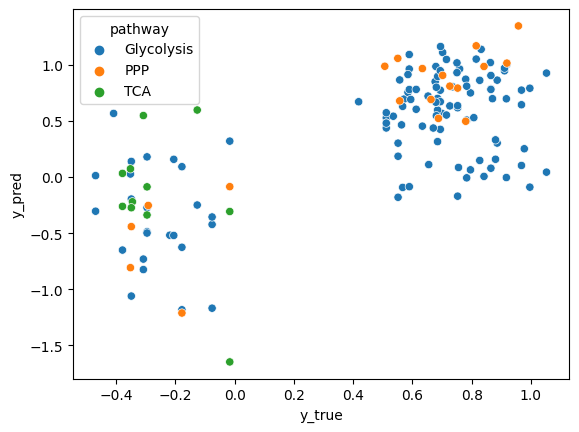

In [9]:
sns.scatterplot(
    data=explanation_df,
    x='y_true',
    y='y_pred',
    hue='pathway',
)

<AxesSubplot:xlabel='exp_enzymes', ylabel='count'>

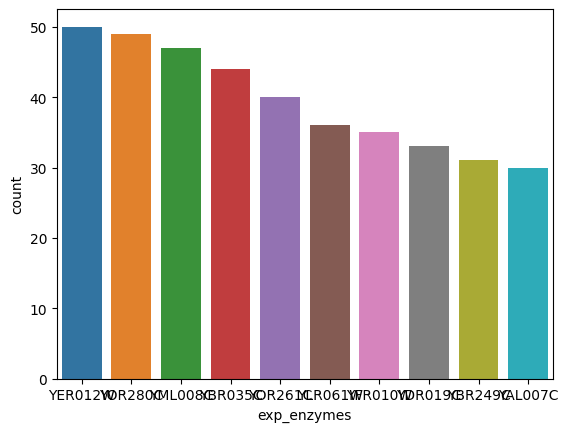

In [13]:
_df = explanation_df.explode(['exp_enzymes', 'exp_weights'])
sns.countplot(
    data=_df,
    x='exp_enzymes',
    order=_df['exp_enzymes'].value_counts().iloc[:10].index
)

In [27]:
explanation_df.explode(['exp_enzymes', 'exp_weights']).groupby(by='metabolite_id')['exp_enzymes'].unique()

metabolite_id
3pg;2pg          [YER012W, YML008C, YGL255W, YOR261C, YPL143W, ...
accoa            [YHR174W, YJL020C, YGL256W, YDR533C, YDR127W, ...
akg              [YOR280C, YFR010W, YML008C, YGR001C, YGL048C, ...
dhap             [YER012W, YAL007C, YBR035C, YDR368W, YPR062W, ...
f6p              [YER012W, YLR438W, YBR035C, YPR024W, YLR061W, ...
g6p;f6p;g6p-B    [YER012W, YOR280C, YAL007C, YDR234W, YDR127W, ...
g6p;g6p-B        [YGR254W, YDR533C, YLR061W, YGL256W, YHR174W, ...
oaa              [YOR280C, YDR019C, YFR010W, YLR438W, YER062C, ...
pep              [YDR019C, YAL007C, YGR175C, YIL063C, YPR024W, ...
pyr              [YOR280C, YLR061W, YDR019C, YFR010W, YJL171C, ...
r5p              [YBR035C, YAL007C, YFR010W, YPR024W, YDR427W, ...
Name: exp_enzymes, dtype: object

#### Throttle analysis

[(0.1, 9.0)]

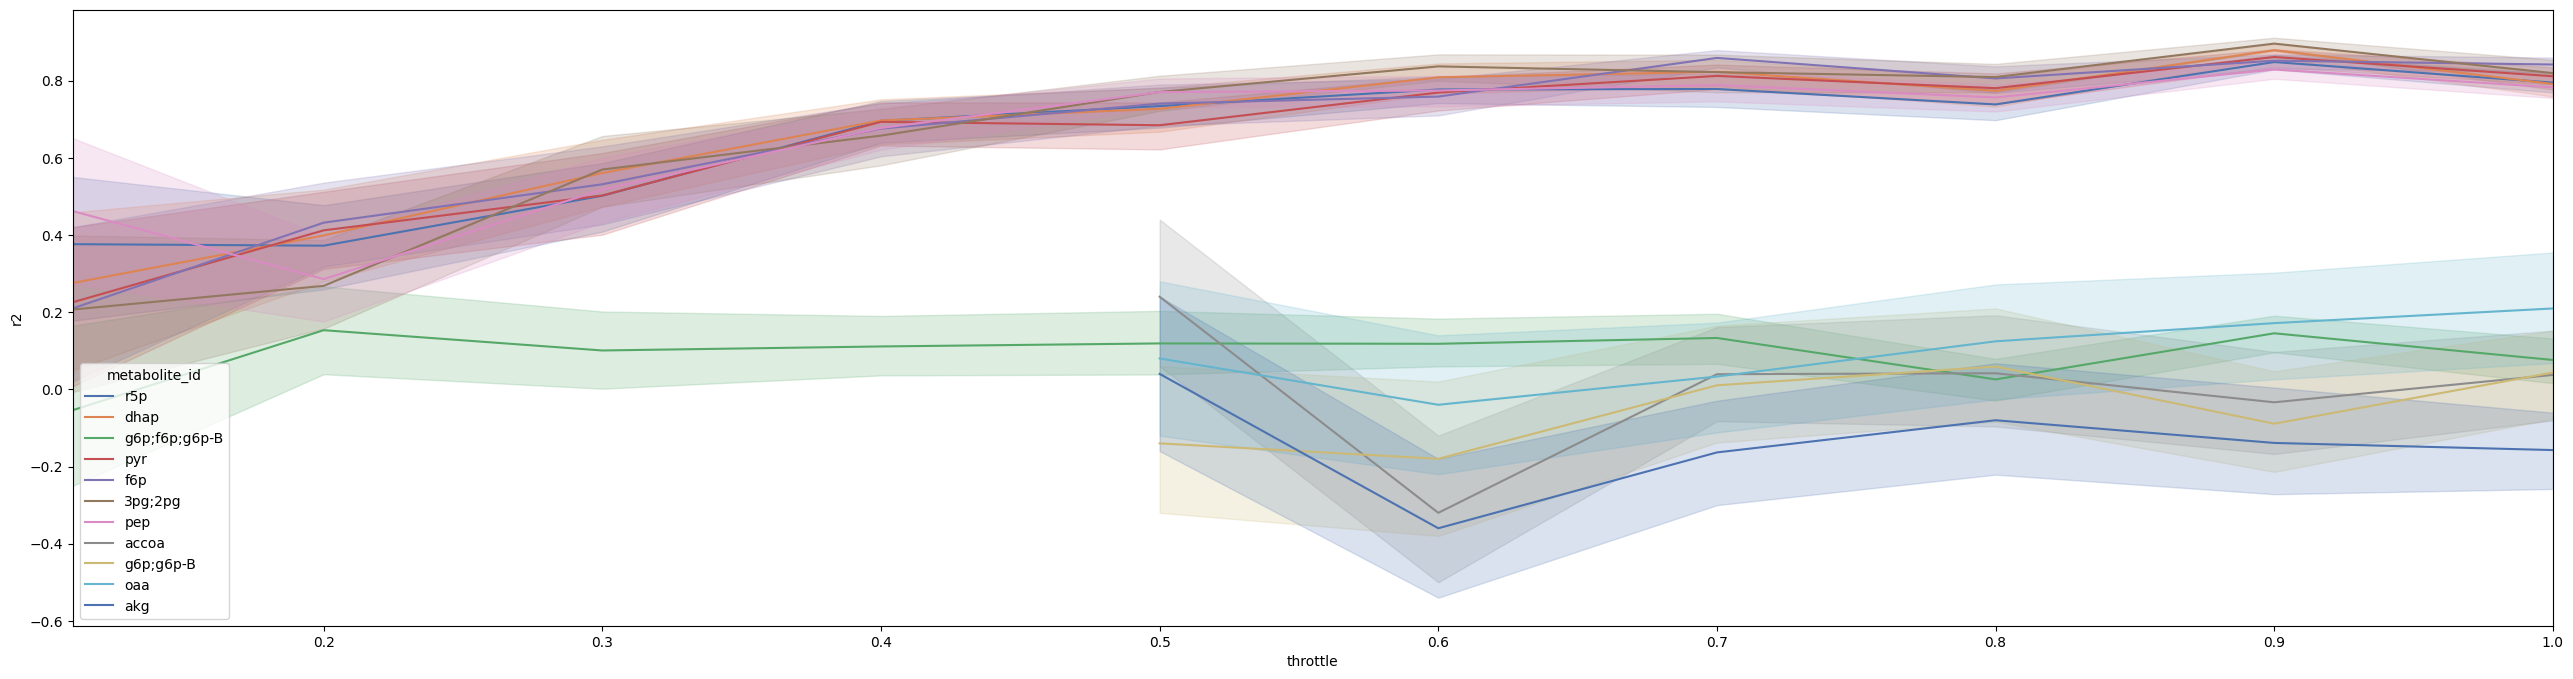

In [8]:
g = sns.lineplot(
    data=test_throttle_df,
    x='throttle',
    y='r2',
    hue='metabolite_id',
    palette='deep',
)
g.set(xlim=(0.1, 9.0))

### Strategy metabolic

In [ ]:
dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0"
paths = glob.glob(dir + "/Strategy.METABOLITE_CENTRIC*.csv")

df = gather_results(paths)
df = fmt_cv_results(df)
df = combine_metabolite_info(df)

test_df = pd.read_csv(
    f'{dir}/best_model_performance.csv',
    index_col=0
)
test_df = test_df.stack().to_frame().reset_index(1).set_axis(['metabolite_id', 'r2'], axis=1)
test_df = test_df.merge(metabolite_info, left_on='metabolite_id', right_index=True)

test_pred_df = pd.read_json(
    f'{dir}/best_model_prediction_performance.json'
)
test_pred_df = test_pred_df.T.reset_index().set_axis(['metabolite_id', 'y_true', 'y_pred'], axis=1) \
    .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
    .explode(['y_true', 'y_pred'])

cv_fgures = CVFigures(df)
pred_figures = PredictionFigures(test_pred_df)
test_figures = TestFigures(test_df)

In [ ]:
cv_fgures.cv_results()

In [ ]:
test_figures.r2_per_metabolite()

In [ ]:
pred_figures.prediction_per_pathway_all()

In [ ]:
pred_figures.prediction_per_pathway_individual()

In [ ]:
pred_figures.prediction_per_metabolite_individual()

## Experiments simple baseline (TIER 1)

### Strategy all

In [ ]:
dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_1"
df = pd.read_csv(f'{dir}/Strategy.ALL_all.csv')
df = fmt_cv_results(df)
df

In [ ]:
test_df = pd.read_csv(
    f'{dir}/best_model_performance_Strategy.ALL.csv',
    index_col=0
)
test_df = test_df.stack().to_frame().reset_index(1).set_axis(['metabolite_id', 'r2'], axis=1)
test_df = test_df.merge(metabolite_info, left_on='metabolite_id', right_index=True)

test_pred_df = pd.read_json(
    f'{dir}/best_model_prediction_performance_Strategy.ALL.json'
)
test_pred_df = test_pred_df.T.reset_index().set_axis(['metabolite_id', 'y_true', 'y_pred'], axis=1) \
    .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
    .explode(['y_true', 'y_pred'])

In [ ]:
pred_figures = PredictionFigures(test_pred_df)
test_figures = TestFigures(test_df)

In [ ]:
pred_figures.prediction_per_pathway_all()

In [ ]:
test_figures.r2_per_metabolite()

In [ ]:
pred_figures.prediction_per_pathway_individual()

In [ ]:
pred_figures.prediction_per_metabolite_individual()